# Monografía Final
## Redes Neuronales - FIUBA
### Alumno: Julián Stejman

En este documento se utilizará una red neuronal entrenada con un algoritmo de aprendizaje por refuerzo PPO (Proximal Policy Optimization) que aprendiese a jugar niveles de Super Mario Bros para la NES. Para ello, se utilizará el entorno de OpenAI Gym, que simula el juego de Super Mario Bros, junto con LSTM para capturar dependencias temporales.

In [1]:
%pip install gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import RIGHT_ONLY
import torch
import torch.nn as nn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.9 MB/s eta 0:00:00
  Created wheel for nes-py: filename=nes_py-8.2.1-cp310-cp310-linux_x86_64.whl size=535720 sha256=2ced3cfbdab8506789bae2ecbb76c06e663be02efeb34603c483de7310a9b383
  Stored in directory: /root/.cache/pip/wheels/34/a7/d5/9aa14b15df740a53d41f702e4c795731b6c4da7925deb8476c
Successfully built nes-py
Note: you may need to restart the kernel to use updated packages.


In [2]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Si se eliminara en la siguiente celda la línea que dice %%skip, se podría ver una simulación simple de como funciona el emulador del juego con el entorno. 

In [3]:

%%skip
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

done = True
for step in range(5000):
    if done:
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()

env.close()

La idea sería armar una red neuronal convolucional para poder interpretar de las imágenes recibidas una posible acción para que tomara el personaje del juego. Esta red luego utilizará un algoritmo de aprendizaje por refuerzo para poder mejorar su desempeño.

La arquitectura utiliza una red Actor-Critic que procesa las imágenes del juego a través de capas convolucionales, seguidas por una LSTM para capturar dependencias temporales. El Actor predice la distribución de probabilidades sobre acciones (policy), mientras que el Critic estima el valor esperado del estado para el cálculo del advantage.

In [4]:
class PPOActorCritic(nn.Module):
    def __init__(self, input_shape, num_actions, hidden_size=128):
        super().__init__()
        
        # Capas convolucionales para procesamiento de imágenes
        self.image_processing = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        # Calcular tamaño de salida de las conv
        flatten_size = self._get_flatten_size(input_shape)
        
        # LSTM para dependencias temporales
        self.lstm = nn.LSTM(flatten_size, hidden_size=hidden_size, batch_first=True)
        self.hidden_size = hidden_size
        
        # Capas Actor y Critic
        self.actor = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_actions)
        )
        
        self.critic = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
    def _get_flatten_size(self, input_shape):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            output = self.image_processing(dummy_input)
            return int(output.view(1, -1).size(1))
    
    def forward(self, x, hidden_state=None):
        """
        x: (batch_size, seq_len, channels, height, width)
        hidden_state: (h, c) tuple de LSTM o None
        """
        # Procesar imágenes
        batch_size, seq_len = x.size(0), x.size(1)
        x = x.view(batch_size * seq_len, *x.shape[2:])
        x = self.image_processing(x)
        x = x.view(batch_size * seq_len, -1)
        x = x.view(batch_size, seq_len, -1)
        
        # LSTM
        if hidden_state is None:
            x, hidden_state = self.lstm(x)
        else:
            x, hidden_state = self.lstm(x, hidden_state)
        
        # Usar solo el último output
        x = x[:, -1, :]
        
        # Actor y Critic
        action_logits = self.actor(x)
        value = self.critic(x)
        
        return action_logits, value, hidden_state

In [5]:
frame_stack_count = 4
dimensions = 84
input_shape = (frame_stack_count, dimensions, dimensions)
num_actions = len(RIGHT_ONLY)

test_model = PPOActorCritic(input_shape, num_actions)
dummy_state = torch.zeros(1, 1, *input_shape)  # (batch_size, seq_len, channels, height, width)
action_logits, value, hidden_state = test_model(dummy_state)
print(f"Action logits shape: {action_logits.shape}")
print(f"Value shape: {value.shape}")
print(f"Number of actions: {num_actions}")

Action logits shape: torch.Size([1, 5])
Value shape: torch.Size([1, 1])
Number of actions: 5


Para enviar a la red, se toma la decisión de mandar los colores a blanco y negro,bajarle la resolución a 84x84 que es la que se suele utilizar para este tipo de ensayos, y de devolver en cada estado 4 cuadros. De esta forma la red podrá aprender en cada estado con más información del entorno y menos en definición visual

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


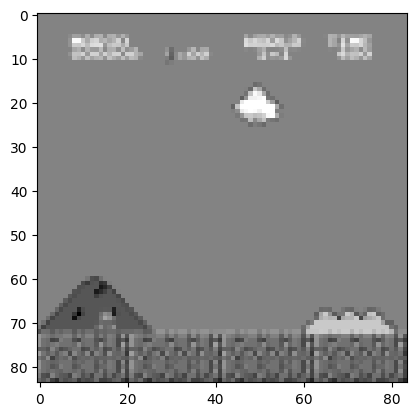

In [6]:
import gym
from gym.wrappers import GrayScaleObservation, FrameStack, ResizeObservation

# Create the Super Mario environment
env = gym.make('SuperMarioBros-v0')

# Apply the wrappers for preprocessing
env = GrayScaleObservation(env, keep_dim=True)  # Convert to grayscale (removes color channels)
env = ResizeObservation(env, shape=(dimensions,dimensions))     # Resize to 84x84
env = FrameStack(env, num_stack=frame_stack_count)               # Stack 4 frames

# Reset the environment to start
state = env.reset()

# Visualize the preprocessed frame (optional)
import matplotlib.pyplot as plt
plt.imshow(state[0], cmap='gray')  # Show the first frame in the stack
plt.show()


Para el entrenamiento con PPO, se utiliza un rollout buffer que acumula experiencias de un episodio completo o de N pasos de interacción. A diferencia de DQN (off-policy), PPO es on-policy: utiliza las experiencias para actualizar la red y luego las descarta, enfocándose en lo más reciente.

In [7]:
from collections import deque
import numpy as np

def preprocess_state(state):
    """
    Preprocesa el estado del juego:
    - Convierte a escala de grises
    - Normaliza entre 0-1
    - Redimensiona a 84x84
    """
    # Hacer copia para evitar problemas con strides negativos
    if isinstance(state, np.ndarray):
        state = state.copy()
    
    state = torch.tensor(state, dtype=torch.float32)
    
    # Si está en RGB (3 canales), convertir a escala de grises
    if len(state.shape) == 3:
        # Media ponderada: luminancia = 0.299*R + 0.587*G + 0.114*B
        state = 0.299 * state[:,:,0] + 0.587 * state[:,:,1] + 0.114 * state[:,:,2]
    
    # Normalizar a [0, 1]
    state = state / 255.0
    
    # Redimensionar a 84x84 si es necesario
    if state.shape != (84, 84):
        import torch.nn.functional as F
        state = F.interpolate(state.unsqueeze(0).unsqueeze(0), size=(84, 84), mode='bilinear', align_corners=False)
        state = state.squeeze(0).squeeze(0)
    
    return state

class CustomFrameStack:
    """
    Mantiene un stack de los últimos k frames.
    Necesario porque LSTM necesita secuencias temporales para capturar dependencias.
    """
    def __init__(self, k=4):
        self.k = k
        self.frames = deque(maxlen=k)
    
    def reset(self, state):
        """Resetea el stack e inicializa con el nuevo estado"""
        state = preprocess_state(state)
        self.frames.clear()
        # Llenar con el mismo frame inicial
        for _ in range(self.k):
            self.frames.append(state)
        return self.get_state()
    
    def push(self, state):
        """Agrega un nuevo frame al stack"""
        state = preprocess_state(state)
        self.frames.append(state)
        return self.get_state()
    
    def get_state(self):
        """Retorna el stack actual como (k, 84, 84)"""
        return torch.stack(list(self.frames))

class RolloutBuffer:
    """
    Buffer on-policy para PPO: almacena experiencias hasta end_episode()
    
    A diferencia de DQN, PPO es on-policy: recolecta experiencias, 
    las usa para actualizar, y luego las descarta.
    """
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []
    
    def push(self, state, action, reward, value, log_prob, done):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.values.append(value)
        self.log_probs.append(log_prob)
        self.dones.append(done)
    
    def compute_returns_and_advantages(self, gamma=0.99, gae_lambda=0.95):
        """
        Calcula returns y advantages usando Generalized Advantage Estimation (GAE)
        
        GAE mezcla TD de corto plazo con Monte Carlo de largo plazo.
        λ = 0.95 da buen balance entre bias y varianza.
        """
        returns = []
        advantages = []
        gae = 0
        next_value = 0
        
        # Iterar hacia atrás a través de los rewards
        for t in reversed(range(len(self.rewards))):
            if t == len(self.rewards) - 1:
                next_non_terminal = 1.0 - self.dones[t]
                next_value = 0
            else:
                next_non_terminal = 1.0 - self.dones[t]
                next_value = self.values[t + 1]
            
            # δ_t = r_t + γ*V(s_{t+1}) - V(s_t)
            delta = self.rewards[t] + gamma * next_value * next_non_terminal - self.values[t]
            # gae_t = δ_t + (γλ) * gae_{t+1}
            gae = delta + gamma * gae_lambda * next_non_terminal * gae
            
            returns.insert(0, gae + self.values[t])
            advantages.insert(0, gae)
        
        return torch.tensor(returns, dtype=torch.float32), torch.tensor(advantages, dtype=torch.float32)
    
    def clear(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []

## Función de Entrenamiento PPO Corregida

### Cambios principales:

**1. FrameStack integrado**
- Ahora sí usamos 4 frames: `(4, 84, 84)` para cada estado
- La LSTM recibe secuencias con información temporal real

**2. Dimensiones correctas**
- Estado individual: `(4, 84, 84)`
- Estado batch: `(batch_size, 1, 4, 84, 84)` donde `1` es la secuencia de longitud 1
- La LSTM procesa esta dimensión de secuencia

**3. Hidden state persistente**
- El `hidden_state` de LSTM se mantiene entre pasos dentro del mismo episodio
- Permite que la LSTM recuerde información del pasado

**4. Mejor logging**
- Mostramos reward del episodio, promedio de últimos 10, y cantidad de pasos
- Checkpoints automáticos cada N episodios

### Flujo del entrenamiento:
```
Para cada episodio:
  1. Recolectar experiencias (rollout)
     - Forward pass en modelo
     - Sample acción y guardar (state, action, reward, log_prob, value)
  2. Calcular returns y advantages con GAE
  3. Normalizar advantages
  4. Para cada época (4 típicamente):
     - Pasar por mini-batches
     - Calcular PPO loss (clipped objective)
     - Actualizar modelo
  5. Guardar checkpoint cada 10 episodios
```

## Preprocesamiento y Frame Stacking

### Preprocesamiento (`preprocess_state`)
Cada frame del juego se procesa:
1. **Conversión a escala de grises**: Reduce de 3 canales (RGB) a 1. Usamos luminancia estándar: `0.299*R + 0.587*G + 0.114*B`
2. **Normalización**: Divide entre 255 para llevar valores a [0, 1]
3. **Redimensionamiento**: Convierte a 84×84 (tamaño estándar en RL)

**Ventajas**: Menos memoria, entrenamiento más rápido, sin perder información importante.

### Frame Stacking (`CustomFrameStack`)
¿Por qué necesitamos 4 frames?
- **Un frame no contiene información de velocidad**: No sabemos si Mario se mueve izquierda, derecha o está parado
- **LSTM necesita secuencias**: Sin múltiples frames, la LSTM no puede aprender dependencias temporales
- **4 frames es estándar**: Es suficiente para capturar movimiento y velocidad

El stack siempre tiene exactamente 4 frames: `(4, 84, 84)`

**Nota**: Usamos `CustomFrameStack` para nuestro preprocesamiento interno, y `gym.wrappers.FrameStack` para el entorno.

In [8]:
def diagnostico_training(rewards, window=10):
    """
    Análisis detallado del entrenamiento para detectar problemas
    """
    print(f"\n{'='*70}")
    print(f"🔍 DIAGNÓSTICO DEL ENTRENAMIENTO")
    print(f"{'='*70}\n")
    
    # 1. Estadísticas básicas
    print(f"📊 Estadísticas Generales:")
    print(f"   Total episodios: {len(rewards)}")
    print(f"   Reward promedio: {np.mean(rewards):.2f}")
    print(f"   Reward std: {np.std(rewards):.2f}")
    print(f"   Reward máximo: {max(rewards):.2f}")
    print(f"   Reward mínimo: {min(rewards):.2f}\n")
    
    # 2. Tendencia
    if len(rewards) >= 20:
        first_half = rewards[:len(rewards)//2]
        second_half = rewards[len(rewards)//2:]
        improvement = np.mean(second_half) - np.mean(first_half)
        
        print(f"📈 Tendencia:")
        print(f"   Primera mitad avg: {np.mean(first_half):.2f}")
        print(f"   Segunda mitad avg: {np.mean(second_half):.2f}")
        print(f"   Mejora: {improvement:+.2f} ", end="")
        
        if improvement > 50:
            print("✅ (Buena progresión)")
        elif improvement > 0:
            print("⚠️  (Mejora lenta)")
        else:
            print("❌ (Sin mejora o empeorando)")
        print()
    
    # 3. Últimos episodios
    if len(rewards) >= window:
        recent = rewards[-window:]
        print(f"🎯 Últimos {window} episodios:")
        print(f"   Promedio: {np.mean(recent):.2f}")
        print(f"   Mejor: {max(recent):.2f}")
        print(f"   Peor: {min(recent):.2f}")
        print(f"   Std: {np.std(recent):.2f} ", end="")
        
        if np.std(recent) > 200:
            print("⚠️  (Alta varianza - exploración activa)")
        elif np.std(recent) < 10:
            print("❌ (Muy baja varianza - colapsó a política fija)")
        else:
            print("✅ (Varianza saludable)")
        print()
    
    # 4. Estancamiento
    if len(rewards) >= 30:
        last_30 = rewards[-30:]
        moving_avg = np.convolve(last_30, np.ones(10)/10, mode='valid')
        
        if len(moving_avg) > 1:
            trend = np.polyfit(range(len(moving_avg)), moving_avg, 1)[0]
            print(f"📉 Análisis de estancamiento (últimos 30):")
            print(f"   Pendiente del promedio móvil: {trend:.3f}")
            
            if abs(trend) < 0.5:
                print("   ❌ ESTANCADO - Considerar:")
                print("      • Aumentar entropy_coef_start a 0.1")
                print("      • Reducir clip_ratio a 0.1")
                print("      • Modificar reward shaping")
                print("      • Reiniciar entrenamiento desde cero")
            elif trend > 0:
                print("   ✅ Mejorando gradualmente - seguir entrenando")
            else:
                print("   ⚠️  Decayendo - posible overfitting")
    
    print(f"\n{'='*70}")

# Ejemplo de uso (descomentar después de entrenar):
# diagnostico_training(improved_rewards)

print("✅ Función de diagnóstico cargada. Úsala con: diagnostico_training(improved_rewards)")

✅ Función de diagnóstico cargada. Úsala con: diagnostico_training(improved_rewards)


In [ ]:
def train_ppo_improved(env, model, num_episodes=100, rollout_steps=2048, num_epochs=4,
                       batch_size=64, gamma=0.99, gae_lambda=0.95, learning_rate=3e-4,
                       clip_ratio=0.2, entropy_coef_start=0.05, entropy_coef_end=0.01, 
                       value_coef=0.5, device="cpu", checkpoint_freq=10, 
                       checkpoint_path="mario_ppo.pt"):
    """
    Versión MEJORADA de train_ppo con:
    - Reward shaping más denso
    - Entropy decay para mejor exploración inicial
    - Learning rate decay
    - Mejor manejo de stuck counter
    """
    model.to(device)
    model.train()  # Asegurar que está en modo entrenamiento
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    total_rewards = []
    best_reward = -float('inf')
    step_count = 0
    
    for episode in range(num_episodes):
        # ========== DECAY SCHEDULES ==========
        # Entropy decay: alta exploración al inicio, baja al final
        progress = episode / num_episodes
        entropy_coef = entropy_coef_start + (entropy_coef_end - entropy_coef_start) * progress
        
        # Learning rate decay
        lr = learning_rate * (1.0 - 0.9 * progress)  # Decae a 10% del LR inicial
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        
        # Stuck threshold: más permisivo al inicio
        stuck_threshold = int(300 + 400 * progress)  # 300 → 700
        
        # ========== RECOLECCIÓN DE EXPERIENCIAS ==========
        state = env.reset()
        frame_stack = CustomFrameStack(k=4)
        stacked_state = frame_stack.reset(state)
        
        buffer = RolloutBuffer()
        episode_reward = 0
        episode_length = 0
        done = False
        hidden_state = None
        
        if (episode + 1) % 10 == 0 or episode == 0:
            print(f"\nEpisodio {episode + 1}/{num_episodes} [LR: {lr:.2e}, Entropy: {entropy_coef:.3f}]")
        
        prev_x_pos = 40
        prev_score = 0
        stuck_counter = 0
        
        while not done:
            state_batch = stacked_state.unsqueeze(0).unsqueeze(0).to(device)
            
            with torch.no_grad():
                action_logits, value, hidden_state = model(state_batch, hidden_state)
                probs = torch.softmax(action_logits, dim=-1)
                dist = torch.distributions.Categorical(probs)
                action = dist.sample()
                log_prob = dist.log_prob(action)
            
            step_result = env.step(action.item())
            if len(step_result) == 5:
                next_state, reward, terminated, truncated, info = step_result
                done = terminated or truncated
            else:
                next_state, reward, done, info = step_result
            
            # ========== REWARD SHAPING MEJORADO ==========
            current_x_pos = info.get('x_pos', prev_x_pos)
            current_score = info.get('score', 0)
            
            # 1. Recompensa por avanzar (menos agresiva)
            x_progress = current_x_pos - prev_x_pos
            reward += x_progress * 1.0
            if info.get('x_pos') > 722:
                reward += 500
            
            # 2. Recompensa por sobrevivir (incentivo constante)
            reward += 0.1
            
            # 3. Manejo de estancamiento
            if x_progress <= 0:
                stuck_counter += 1
                if stuck_counter > stuck_threshold:
                    reward -= 1.0
                    done = True  # Terminar episodio
            else:
                stuck_counter = max(0, stuck_counter - 2)  # Resetear gradualmente
            
            prev_x_pos = current_x_pos
            prev_score = current_score
            
            next_stacked_state = frame_stack.push(next_state)
            
            buffer.push(
                stacked_state.cpu().numpy(),
                action.item(),
                reward,
                value.item(),
                log_prob.item(),
                float(done)
            )
            
            episode_reward += reward
            stacked_state = next_stacked_state
            step_count += 1
            episode_length += 1
        
        # ========== CÁLCULO DE RETURNS Y ADVANTAGES ==========
        returns, advantages = buffer.compute_returns_and_advantages(gamma, gae_lambda)
        
        states_array = np.array(buffer.states)
        states_tensor = torch.tensor(states_array, dtype=torch.float32).to(device)
        actions_tensor = torch.tensor(buffer.actions, dtype=torch.long).to(device)
        old_log_probs = torch.tensor(buffer.log_probs, dtype=torch.float32).to(device)
        
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        advantages = advantages.to(device)
        returns = returns.to(device)
        
        # ========== ACTUALIZACIÓN PPO ==========
        num_batches = max(1, len(buffer.states) // batch_size)
        
        for epoch in range(num_epochs):
            indices = torch.randperm(len(buffer.states), device=device)
            
            for batch_idx in range(num_batches):
                start_idx = batch_idx * batch_size
                end_idx = min(start_idx + batch_size, len(buffer.states))
                batch_indices = indices[start_idx:end_idx]
                
                batch_states = states_tensor[batch_indices].unsqueeze(1)
                batch_actions = actions_tensor[batch_indices]
                batch_old_log_probs = old_log_probs[batch_indices]
                batch_advantages = advantages[batch_indices]
                batch_returns = returns[batch_indices]
                
                action_logits, values, _ = model(batch_states)
                probs = torch.softmax(action_logits, dim=-1)
                dist = torch.distributions.Categorical(probs)
                new_log_probs = dist.log_prob(batch_actions)
                entropy = dist.entropy().mean()
                
                ratio = torch.exp(new_log_probs - batch_old_log_probs)
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1.0 - clip_ratio, 1.0 + clip_ratio) * batch_advantages
                actor_loss = -torch.min(surr1, surr2).mean()
                
                value_loss = ((values.squeeze() - batch_returns) ** 2).mean()
                
                # Usar entropy_coef dinámico
                total_loss = actor_loss + value_coef * value_loss - entropy_coef * entropy
                
                optimizer.zero_grad()
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                optimizer.step()
        
        total_rewards.append(episode_reward)
        
        avg_10 = np.mean(total_rewards[-10:]) if len(total_rewards) >= 10 else np.mean(total_rewards)
        max_reward = max(total_rewards)
        
        if (episode + 1) % 10 == 0 or episode == 0:
            print(f"  Reward: {episode_reward:.1f} | Avg(10): {avg_10:.1f} | Max: {max_reward:.1f}")
            print(f"  Steps: {episode_length} | X_pos: {prev_x_pos:.0f} | Stuck: {stuck_counter}/{stuck_threshold}")
        
        if episode_reward > best_reward:
            best_reward = episode_reward
            best_checkpoint_path = checkpoint_path.replace('.pt', '_best.pt')
            save_checkpoint(model, total_rewards, best_checkpoint_path, device)
            if (episode + 1) % 10 == 0 or episode == 0:
                print(f"Nuevo mejor: {best_reward:.1f}")
        
        if (episode + 1) % checkpoint_freq == 0:
            save_checkpoint(model, total_rewards, checkpoint_path, device)
    
    return total_rewards

def save_checkpoint(model, rewards, path, device="cpu"):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "rewards": rewards,
        "device": device,
    }
    torch.save(checkpoint, path)
    
def load_checkpoint(model, path, device="cpu"):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    rewards = checkpoint.get("rewards", [])
    model.to(device)
    # No poner en eval(), dejar que la función que llama decida el modo
    return model, rewards

In [10]:
"""
=== CONFIGURACIÓN INICIAL DEL ENTRENAMIENTO ===

Aquí inicializamos:
- El dispositivo (GPU si está disponible)
- El modelo PPO con arquitectura Actor-Critic + LSTM
- Intentamos cargar un checkpoint anterior si existe
"""

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✓ Dispositivo a usar: {device}")

# Inicializar modelo
model = PPOActorCritic(input_shape, num_actions, hidden_size=128)

# Intentar cargar checkpoint anterior para continuar entrenamiento
checkpoint_path = "mario_ppo_checkpoint.pt"
try:
    model, prev_rewards = load_checkpoint(model, checkpoint_path, device)
    print(f"✓ Reanudando entrenamiento con {len(prev_rewards)} episodios previos")
    print(f"  Mejor reward: {max(prev_rewards):.2f}")
    print(f"  Último reward: {prev_rewards[-1]:.2f}")
except FileNotFoundError:
    print("ⓘ No se encontró checkpoint anterior. Comenzando entrenamiento desde cero.")

✓ Dispositivo a usar: cuda
ⓘ No se encontró checkpoint anterior. Comenzando entrenamiento desde cero.


<ipython-input-9-d648aa2d02e9>:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)



=== VERIFICACIÓN DEL AMBIENTE ===
✓ Estado shape: (240, 256, 3), dtype: uint8
✓ env.step() devuelve 4 valores
✓ Action space: 5 acciones
=== FIN VERIFICACIÓN ===

✓ Entorno configurado correctamente (sin wrappers de preprocesamiento)


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):



Episodio 1/250 [LR: 3.00e-04, Entropy: 0.050]
  Reward: 611.4 | Avg(10): 611.4 | Max: 611.4
  Steps: 584 | X_pos: 594 | Stuck: 301/300
  ⭐ Nuevo mejor: 611.4

Episodio 10/250 [LR: 2.90e-04, Entropy: 0.049]
  Reward: 628.6 | Avg(10): 626.2 | Max: 645.3
  Steps: 756 | X_pos: 594 | Stuck: 315/314

Episodio 20/250 [LR: 2.79e-04, Entropy: 0.047]
  Reward: 452.2 | Avg(10): 630.1 | Max: 751.4
  Steps: 582 | X_pos: 434 | Stuck: 331/330

Episodio 30/250 [LR: 2.69e-04, Entropy: 0.045]
  Reward: 643.0 | Avg(10): 631.2 | Max: 751.4
  Steps: 890 | X_pos: 594 | Stuck: 347/346

Episodio 40/250 [LR: 2.58e-04, Entropy: 0.044]
  Reward: 450.3 | Avg(10): 556.7 | Max: 751.4
  Steps: 573 | X_pos: 434 | Stuck: 363/362

Episodio 50/250 [LR: 2.47e-04, Entropy: 0.042]
  Reward: 620.0 | Avg(10): 610.9 | Max: 751.4
  Steps: 650 | X_pos: 594 | Stuck: 379/378

Episodio 60/250 [LR: 2.36e-04, Entropy: 0.041]
  Reward: 621.4 | Avg(10): 622.6 | Max: 765.7
  Steps: 674 | X_pos: 594 | Stuck: 395/394

Episodio 70/250 [L

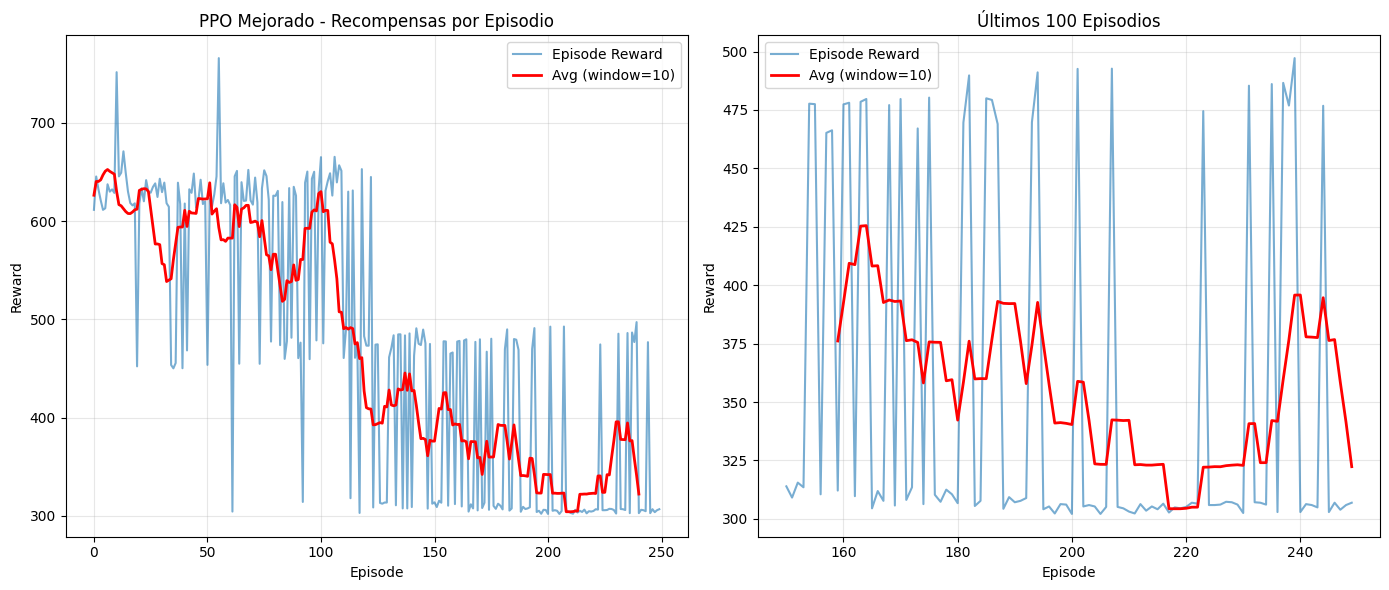


📊 ESTADÍSTICAS FINALES
Reward promedio (últimos 10): 322.33
Reward promedio (últimos 50): 337.5260000000029
Reward máximo: 765.70
Reward mínimo: 302.10

🔍 DIAGNÓSTICO DEL ENTRENAMIENTO

📊 Estadísticas Generales:
   Total episodios: 250
   Reward promedio: 476.05
   Reward std: 139.95
   Reward máximo: 765.70
   Reward mínimo: 302.10

📈 Tendencia:
   Primera mitad avg: 585.90
   Segunda mitad avg: 366.20
   Mejora: -219.70 ❌ (Sin mejora o empeorando)

🎯 Últimos 10 episodios:
   Promedio: 322.33
   Mejor: 476.80
   Peor: 302.90
   Std: 51.51 ✅ (Varianza saludable)

📉 Análisis de estancamiento (últimos 30):
   Pendiente del promedio móvil: 1.979
   ✅ Mejorando gradualmente - seguir entrenando



In [ ]:
# Imports necesarios
import numpy as np
import matplotlib.pyplot as plt

# Configurar entorno con todos los wrappers necesarios
# Nota: NO usamos FrameStack aquí porque CustomFrameStack lo maneja internamente
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, RIGHT_ONLY)

# Verificar ambiente
print("\n=== VERIFICACIÓN DEL AMBIENTE ===")
test_state = env.reset()
print(f"✓ Estado shape: {test_state.shape}, dtype: {test_state.dtype}")
test_result = env.step(0)
print(f"✓ env.step() devuelve {len(test_result)} valores")
print(f"✓ Action space: {env.action_space.n} acciones")
print("=== FIN VERIFICACIÓN ===\n")

print("✓ Entorno configurado correctamente (sin wrappers de preprocesamiento)")

# Entrenamiento con versión mejorada
num_episodes = 250
total_rewards = train_ppo_improved(
    env,
    model,
    num_episodes=num_episodes,
    num_epochs=10,
    batch_size=256,
    gamma=0.99,
    gae_lambda=0.95,
    learning_rate=3e-4,
    clip_ratio=0.2,
    entropy_coef_start=0.1,  # Alta exploración inicial
    entropy_coef_end=0.05,     # Baja al final
    value_coef=0.5,
    device=device,
    checkpoint_freq=10,
    checkpoint_path="mario_ppo_improved.pt"
)

# Visualización de resultados
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(total_rewards, alpha=0.6, label='Episode Reward')
plt.plot(np.convolve(total_rewards, np.ones(10)/10, mode='valid'), 
         label='Avg (window=10)', linewidth=2, color='red')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('PPO Mejorado - Recompensas por Episodio')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# Mostrar últimos 100 episodios para ver tendencia
window = min(100, len(total_rewards))
recent_rewards = total_rewards[-window:]
plt.plot(range(len(total_rewards) - window, len(total_rewards)), 
         recent_rewards, alpha=0.6, label='Episode Reward')
plt.plot(range(len(total_rewards) - window + 9, len(total_rewards)),
         np.convolve(recent_rewards, np.ones(10)/10, mode='valid'),
         label='Avg (window=10)', linewidth=2, color='red')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title(f'Últimos {window} Episodios')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas finales
print(f"\n{'='*60}")
print(f"📊 ESTADÍSTICAS FINALES")
print(f"{'='*60}")
print(f"Reward promedio (últimos 10): {np.mean(total_rewards[-10:]):.2f}")
print(f"Reward promedio (últimos 50): {np.mean(total_rewards[-50:]) if len(total_rewards) >= 50 else 'N/A'}")
print(f"Reward máximo: {max(total_rewards):.2f}")
print(f"Reward mínimo: {min(total_rewards):.2f}")
print(f"{'='*60}")

# Diagnóstico automático
diagnostico_training(total_rewards)

## Inicio del Entrenamiento (Versión Mejorada)

A continuación entrenaremos el modelo con la versión mejorada de PPO que incluye:

**Mejoras implementadas:**
- 🔥 **Entropy decay**: 0.05 → 0.01 (exploración adaptativa)
- 📉 **Learning rate decay**: Reduce oscilaciones
- 🎯 **Reward shaping denso**: sobrevivir + score + avance
- ⏱️ **Stuck threshold adaptativo**: 300 → 700 pasos

**Parámetros clave:**
- **num_episodes=250**: Episodios de entrenamiento
- **rollout_steps=2048**: Pasos antes de actualizar
- **num_epochs=4**: Reutilizar datos 4 veces
- **batch_size=128**: Tamaño de mini-batch
- **clip_ratio=0.2**: PPO clipping estándar

**Expectativas:**
- Primeros 20 episodios: exploración caótica (0-100)
- Episodios 20-50: aprende movimiento básico (100-500)
- Episodios 50+: debería superar obstáculos (>500)

El modelo guardará checkpoints automáticamente y al finalizar mostrará un diagnóstico automático.

In [12]:
"""
=== INFERENCIA: USAR EL MODELO ENTRENADO ===

Aquí jugamos episodios usando la política aprendida.
Usamos acciones deterministas (argmax) para aprovechar lo aprendido.
"""

def play_episode(env, model, device="cpu", max_steps=1000):
    """
    Juega un episodio usando la política aprendida
    
    Args:
        env: Ambiente SuperMario
        model: Modelo PPO Actor-Critic
        device: CPU o CUDA
        max_steps: Máximo de pasos por episodio
    
    Returns:
        total_reward: Recompensa total acumulada
        steps: Número de pasos ejecutados
    """
    model.eval()
    state = env.reset()
    
    # Inicializar frame stack
    frame_stack = CustomFrameStack(k=4)
    stacked_state = frame_stack.reset(state)
    
    total_reward = 0
    done = False
    steps = 0
    hidden_state = None
    
    while not done and steps < max_steps:
        # Convertir a batch: (1, 1, 4, 84, 84)
        state_batch = stacked_state.unsqueeze(0).unsqueeze(0).to(device)
        
        with torch.no_grad():
            action_logits, _, hidden_state = model(state_batch, hidden_state)
            # Usar acción determinista (greedy): la de mayor probabilidad
            action = action_logits.argmax(dim=-1)
        
        next_state, reward, done, info = env.step(action.item())
        
        # Stack frames
        stacked_state = frame_stack.push(next_state)
        
        total_reward += reward
        steps += 1
    
    model.train()
    return total_reward, steps

# ===== TESTING =====
print("Testing trained model...")
print("Ejecutando 5 episodios de prueba...\n")

test_rewards = []
test_steps = []

for i in range(5):
    reward, steps = play_episode(env, model, device=device, max_steps=1000)
    test_rewards.append(reward)
    test_steps.append(steps)
    print(f"Episodio {i+1}: Reward = {reward:7.2f} | Steps = {steps:4d}")

print(f"\n{'='*50}")
print(f"Average reward: {np.mean(test_rewards):.2f} ± {np.std(test_rewards):.2f}")
print(f"Max reward: {max(test_rewards):.2f}")
print(f"Min reward: {min(test_rewards):.2f}")
print(f"Average steps: {np.mean(test_steps):.0f}")
print(f"{'='*50}")

Testing trained model...
Ejecutando 5 episodios de prueba...



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episodio 1: Reward =  741.00 | Steps =  319
Episodio 2: Reward =  741.00 | Steps =  319
Episodio 3: Reward =  741.00 | Steps =  319
Episodio 4: Reward =  741.00 | Steps =  319
Episodio 5: Reward =  741.00 | Steps =  319

Average reward: 741.00 ± 0.00
Max reward: 741.00
Min reward: 741.00
Average steps: 319
